In [11]:
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from tensorflow.keras.models import Model
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns
import matplotlib.pyplot as plt
from astroNN.nn.layers import MCDropout
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp


In [12]:
decoder = tf.keras.models.load_model('../models/decoderJLA.h5')
ffnn = tf.keras.models.load_model('../models/FFNN_JLA.h5') 
autoencoder = tf.keras.models.load_model('../models/autoencoderJLA.h5')
encoder = tf.keras.models.load_model('../models/encoderJLA.h5')

In [13]:
file2 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]
scalerdl = StandardScaler()
scalerdl.fit(dl.reshape(-1, 1))
dll = scalerdl.transform(dl.reshape((-1,1)))

In [14]:
# ranz = np.linspace(0.0, 1.3, 10000)
# ranz = np.zeros(np.shape(z))
# for i, _ in enumerate(ranz):
#     ranz[i] = z[i] + 0.02*np.random.rand()
file3 = '/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/notebooks/fake_binned_JLADO.dat'
data3 = pd.read_csv(file3, names=['z', '$D_L$'], sep = " ", skiprows=3)

ranz = data.values[:,0]

# ranz = z
pred_random = ffnn.predict(ranz)
dlfake = scalerdl.inverse_transform(pred_random.reshape(-1,1))


In [15]:
index = np.argsort(ranz)
fake_data = np.stack((ranz[index], dlfake.reshape(31,)[index]), axis=1)

np.savetxt("fake_binned_JLA2.dat",  fake_data, delimiter= " ", header="#fake data\n# z\n# mu", fmt='%1.9f')



In [16]:
Om = 0.27
# variance network
w0 = -1

# def RHSquared_a_lcdm(a):
# #         return Ezlcdm(a)**2
#     return Om*(1/a)**3 + 1 - Om

def RHSquared_a_owacdm(a, w0, wa):
#         return Ezlcdm(a)**2
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa):
#         if model == 'lcdm':
#             return 1./np.sqrt(RHSquared_a_lcdm(a))/a**2
#         elif model == 'owacdm':
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa))/a**2
    
def Da_z(z, w0, wa):
        # r=intg.quad(self.Hinv_z,0,z)
        # this version seems to be faster
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa))

        r = r[0]
      
        return r
    
def distance_modulus(z, w0=-1, wa=0.0):
        # I think this should also work with varyPrefactor as long as BAO is there too
        # assert(not self.varyPrefactor)

        # note that our Da_z is comoving, so we're only
        # multilpyting with a single (1+z) factor
#         return 5*np.log10(Da_z(z, model, w0, wa)*(1+z)) 
    return 5*np.log10(Da_z(z, w0, wa)*(1+z))+43

In [17]:
zmodel = np.linspace(0.01, 1.5, 100)
flcdm = []
fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

# flcdm = []
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
    fowacdm1.append(distance_modulus(zzz, w0=-10, wa=-100))
#     fowacdm2.append(distance_modulus(zz, model='owacdm', w0=-1, wa=-0.5))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

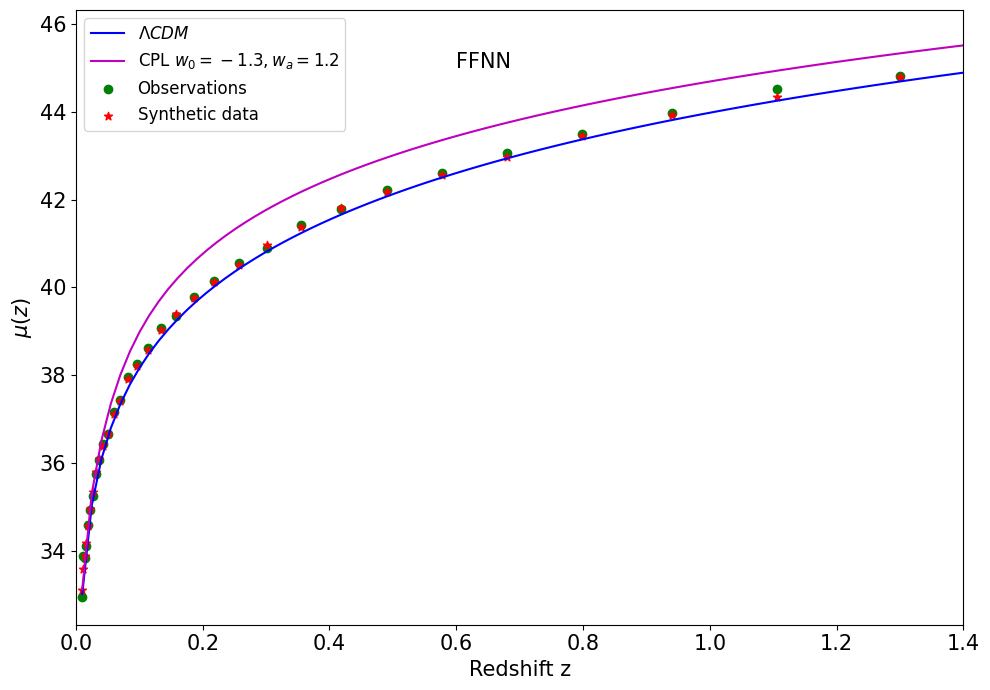

In [18]:
plt.figure(figsize=(10, 7), dpi=100)
# plt.errorbar(ranz, pred_random, yerr=0, fmt='r.', markersize=10.)
# plt.scatter(z, dl)
plt.scatter(z, dl,c='g', label='Observations')
plt.scatter(ranz, dlfake, c='r', label='Synthetic data', marker='*')
# plt.errorbar(z, dl, yerr=0, fmt='g.', markersize=10, label='Observations')
# plt.errorbar(ranz, pred_random, 
#              yerr=0, fmt='r.', markersize=10., label='Synthetic data')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.plot(zmodel, fowacdm1, label='CPL $w_0 = -1.3, w_a=1.2$', c='m')

# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z", fontsize=15)
plt.ylabel("$\mu(z)$", fontsize=15)
plt.xlim(-0.0, np.max(z)+0.1)
plt.xticks(fontsize=15)
plt.text(0.6, 45, 'FFNN', fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=12)
# plt.savefig('jla3.png')

In [19]:
# syscov = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
avg_encoded = np.loadtxt('/home/isidro/Documents/gitHub/misRepos/neuralCosmoReconstruction/notebooks/avg_encoded.txt')
np.shape(avg_encoded)

(31,)

In [20]:
fake_encoded = np.zeros((1, 31))
for i, avg in enumerate(avg_encoded):
    alpha = avg/z[i]
    fake_encoded[0, i] = alpha * ranz[i]

In [21]:
decoded_fake = decoder.predict(fake_encoded)
np.shape(decoded_fake), np.shape(fake_encoded)

((1, 961), (1, 31))

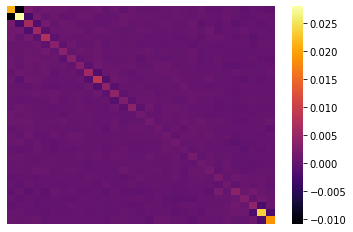

In [22]:
sns.heatmap(pd.DataFrame(decoded_fake[0].reshape(31,31)), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno')

plt.savefig('covFAKE.png')

In [23]:
# np.savetxt("fake_binned_JLA_COVdecoded.dat", decoded_fake[0, :].reshape(31,31), delimiter= " ", 
#            header="#fake COV")
# # , fmt='%1.15f'
